# Heart attack prediction

## Install dependencies

In [ ]:
!pip install -U gdown numpy pandas scikit-learn seaborn

## Download data

In [ ]:
import gdown
gdown.download(id='1yBNUVzUAwb5LeQ9eGD55YVPGq-5HoX4c', output='heart.csv', quiet=False)

## Load & Preprocess data
First the data is loaded and some test set size is selected. To make the analysis reproducible, the seed is set.


In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

SEED = 997
TEST_SIZE = 0.1

data = pd.read_csv('heart.csv')

Dataset contains two categorical variable: `cp` and `restecg`. Those are one-hot encoded in preprocessing. All models used (Logistic Regression, Decision Tree, Random Forest) can benefit from one-hot encoding the categorical variables

In [4]:
def to_one_hot(data, column):
    dummies = pd.get_dummies(data[column])
    for dummy_value in dummies.columns:
        data = pd.concat([data, dummies[dummy_value].rename(f'{column}_{dummy_value}')], axis=1)
    return data.drop(column, axis=1)

data = to_one_hot(data, 'cp')
data = to_one_hot(data, 'restecg')

The data is split into test/train sets.

In [5]:
from sklearn.model_selection import train_test_split

X = data.drop(columns=['output'])
y = data['output']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=SEED)

## Train & evaluate the models

First a helper function is set up and some variables are created for storing experiments results

In [6]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_curve

def check_model_quality(model_name, y_test, y_pred):
  print("Quality with", model_name)
  accuracy = accuracy_score(y_test, y_pred)
  print(f"- Accuracy score: {accuracy:.2f}")
  f1 = f1_score(y_test, y_pred)
  print(f"- F1 score: {f1:.2f}")
  precision = precision_score(y_test, y_pred)
  print(f"- Precision: {precision:.2f}")
  recall = recall_score(y_test, y_pred)
  print(f"- Recall: {recall:.2f}")
  print()
  return accuracy, f1, precision, recall

metrics = pd.DataFrame(columns=['Accuracy', 'F1', 'Precision', 'Recall'])
roc_curves = {}

### Logistic Regression
Logistic regression is one of the simplest model types used in classification. To train it until convergence, `max_iter` parameter needs to be set to a high enoug value.

In [7]:
from sklearn.linear_model import LogisticRegression


logistic_regression = LogisticRegression(random_state=SEED, max_iter=10_000)
logistic_regression.fit(X_train, y_train)

y_pred = logistic_regression.predict(X_test)
score = logistic_regression.predict_proba(X_test)[:, 1]

acc, f1, pr, rc = check_model_quality('Logistic Regression', y_test, y_pred)
metrics.loc['Logistic Regression'] = [acc, f1, pr, rc]
roc_curves['Logistic Regression'] = roc_curve(y_test, score)[:-1]

Quality with Logistic Regression
- Accuracy score: 0.77
- F1 score: 0.84
- Precision: 0.78
- Recall: 0.90



### Decision Tree Classifier
This method works better than linear regression without changing default `sklearn` parameters, so there is no need to tweak them. The ROC curve makes no sense for a single tree classifier so it's not computed.

In [8]:
from sklearn.tree import DecisionTreeClassifier


tree_classifier = DecisionTreeClassifier(random_state=SEED)
tree_classifier.fit(X_train, y_train)

y_pred = tree_classifier.predict(X_test)

acc, f1, pr, rc = check_model_quality('Decision Tree Classifier', y_test, y_pred)
metrics.loc['Decision Tree'] = [acc, f1, pr, rc]

Quality with Decision Tree Classifier
- Accuracy score: 0.84
- F1 score: 0.88
- Precision: 0.86
- Recall: 0.90



### Random Forest Classifier
As before, there is no need to tweak default parameters. In contrast to a single tree classifier, here ROC curve is a meaningful way presenting model's performance. 

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer
from random import gauss

forest_classifier = RandomForestClassifier(random_state=SEED)
forest_classifier.fit(X_train, y_train)


y_pred = forest_classifier.predict(X_test)
score = forest_classifier.predict_proba(X_test)[:, 1]

acc, f1, pr, rc = check_model_quality('Random Forest Classifier', y_test, y_pred)
metrics.loc['Random Forest'] = [acc, f1, pr, rc]
roc_curves['Random Forest'] = roc_curve(y_test, score)[:-1]

Quality with Random Forest Classifier
- Accuracy score: 0.90
- F1 score: 0.93
- Precision: 0.90
- Recall: 0.95



## Results and conclusions

Random Forest improves Decision Classifier, which is better than simple Logistic Regression. The same trend is visible in all relevant chosen metrics (Accuracy, F1, Precision, Recall). All models 

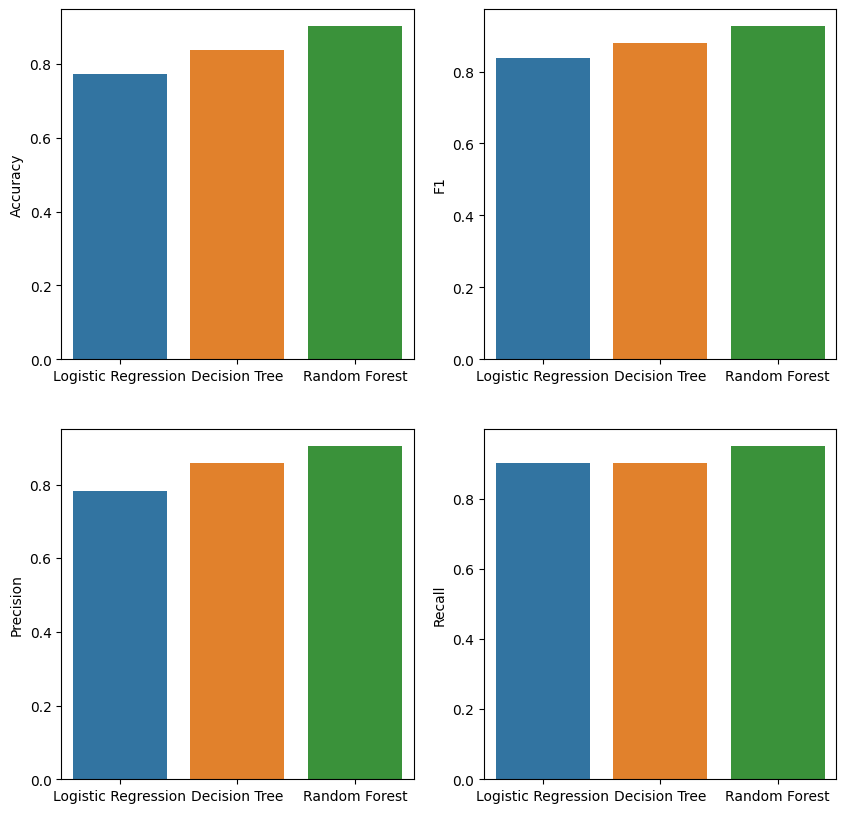

In [10]:
_, axes = plt.subplots(2, 2, figsize=(10, 10))
for m, ax in zip(['Accuracy', 'F1', 'Precision', 'Recall'], ([0, 0], [0, 1], [1, 0], [1, 1])): 
    sns.barplot(x = metrics.index, y = metrics[m], ax=axes[ax[0], ax[1]])

As mentioned before, ROC curve for a Decision Tree is not meaningful, because its output is binary. The sloped region of the Random Forest ROC is causes by low granularity (some values come up multiple times) of RF's probability output. 

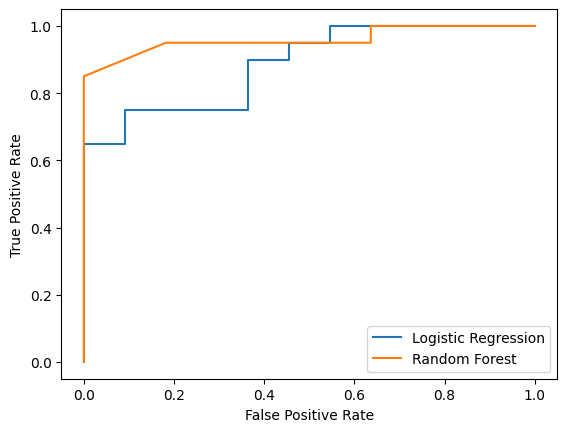

In [11]:
for name, (fpr, tpr) in roc_curves.items():
    plt.plot(fpr, tpr, label=name)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()